# Shapley Flow tutorial

In this notebook, we work through a synthetic example from healthcare. By the end of the tutorial, 
you should be able to 

1. understand the motivation of Shapley Flow
2. able to use the Shapley Flow code base
3. understand the Shapley Flow algorithm

# Overall Idea

Abstract:
Many existing approaches for estimating feature importance are problematic because they ignore or hide dependencies among features. A causal graph, which encodes the relationships among input variables, can aid in assigning feature importance. However, current approaches that assign credit to nodes in the causal graph fail to explain the entire graph. In light of these limitations, we propose Shapley Flow, a novel approach to interpreting machine learning models. It considers the entire causal graph, and assigns credit to \textit{edges} instead of treating nodes as the fundamental unit of credit assignment. Shapley Flow is the unique solution to a generalization of the Shapley value axioms to directed acyclic graphs. We demonstrate the benefit of using Shapley Flow to reason about the impact of a model's input on its output. In addition to maintaining insights from existing approaches, Shapley Flow extends the flat, set-based, view prevalent in game theory based explanation methods to a deeper, \textit{graph-based}, view. This graph-based view enables users to understand the flow of importance through a system, and reason about potential interventions.

R3:
The paper proposes Shapley Flow, a novel method for extending Shapley values to causal graphs by assigning credit not to nodes (i.e., features) but to edges (i.e., causal paths). The resulting algorithm unifies a variety of proposals (independent SHAP, on-manifold Shapley values, asymmetric Shapley values) into a single framework with attractive theoretical properties and strong empirical performance.

R7:
When exploring the problem of estimating feature importance for which we know the causal graph generating the input data, existing approaches exhibit clear limitations: either they completely ignore the dependencies across variables, or they exclusively focus on the source/independent variables of the graph. This work presents a novel algorithm, Shapley Flow, that estimates the importance of the edges of the causal graph instead of the vertices, generalizing several previous approaches. In order to developer the algorithm, the paper extends Shapley value axioms (used in game theory) to graphs by adding a new condition.

This new condition is defined on top on the idea that, given the causal graph where the model acts as a sink, this graph can be partitioned into two sets: one containing the source nodes, and another containing the sink node (the model). Considering a partition, the algorithm considers as tunable inputs/edges those that cross between the two sets. However these partitions are not unique, and the new axiom introduced in this works makes sure that the importance attributed to a vertex is consistent across all the partitions that have it as a tunable edge.

In [1]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import numpy as np
import matplotlib.pyplot as plt
from flow import Node, CreditFlow, Graph, flatten_graph, eval_graph, get_source_nodes, single_source_graph, boundary_graph, viz_graph, save_graph
from collections import defaultdict

# An example in healthcare

$\text{health status} \in \{0, 1\}$

$\text{portable scanner} \in \{0, 1\}$

$\text{mortality probability prediction} \in [0, 1]$


```python
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True) # U(0, 1)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
```

In [3]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: 1,
                     'scanner type noise': lambda: 0.3 # np.random.uniform(0, 1)
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: 0.5 # np.random.uniform(0, 1),
                 })
   
    return graph

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 1014.34it/s]


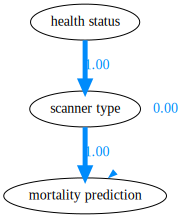

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f4bc10f5930>>

In [4]:
graph = build_health_graph()
cf = CreditFlow(graph, nruns=1, visualize=verbose)
cf.run()

cf.draw()

# Issues with feature attribution methods: showing only direct or indirect effect of features

# Need: show multiple views

# Idea: edge attribution

# How to assign credit? Extending Shapley axioms

# Showing how the algorithm works

bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

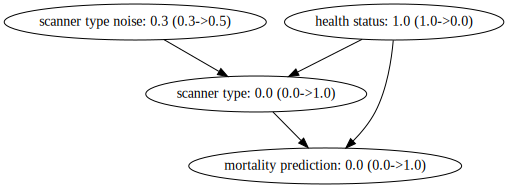


----> using order [health status, scanner type noise]
baselines health status: 1, scanner type noise: 0.3
turn on edge from external source to health status
health status changes from 1 to 0


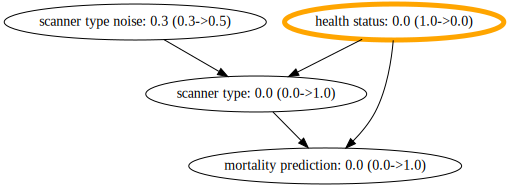

turn on edge health status->scanner type
scanner type changes from 0 to 1


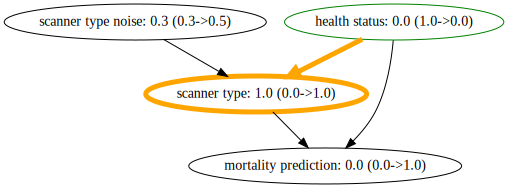

turn on edge scanner type->mortality prediction
mortality prediction changes from 0 to 1


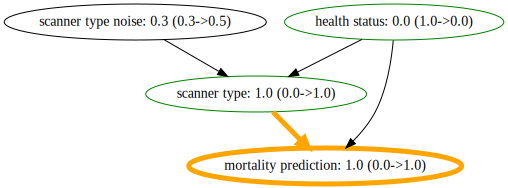

assign 1 credits to scanner type->mortality prediction


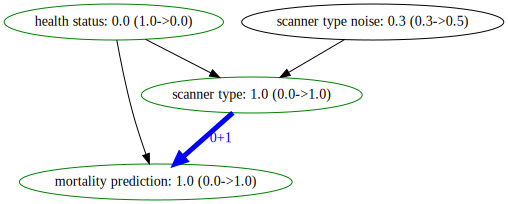

assign 1 credits to health status->scanner type


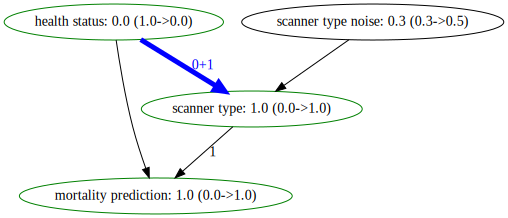

turn on edge health status->mortality prediction
mortality prediction changes from 1 to 1


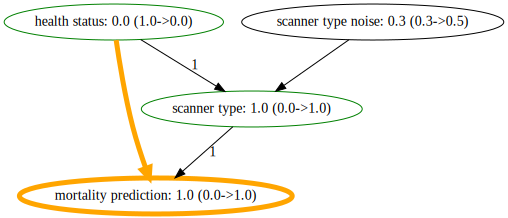

assign 0 credits to health status->mortality prediction


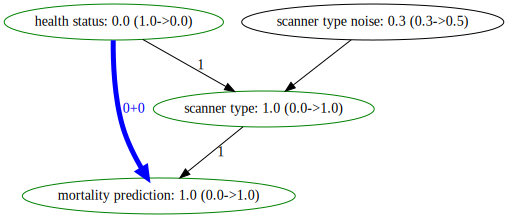

turn on edge from external source to scanner type noise
scanner type noise changes from 0.3 to 0.5


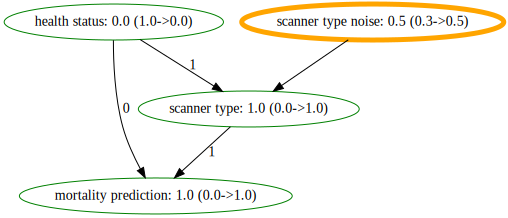

turn on edge scanner type noise->scanner type
scanner type changes from 1 to 1


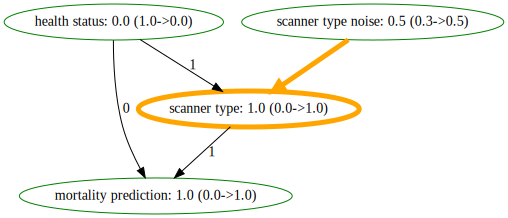

turn on edge scanner type->mortality prediction
mortality prediction changes from 1 to 1


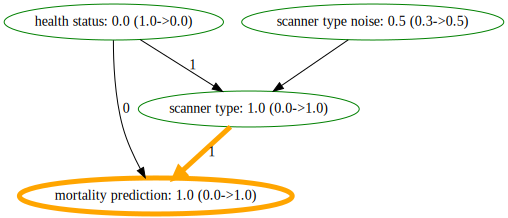

assign 0 credits to scanner type->mortality prediction


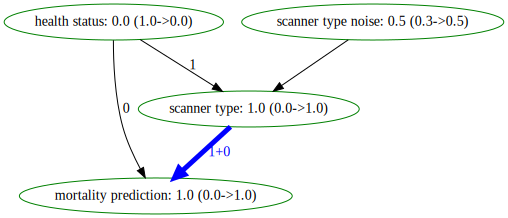

assign 0 credits to scanner type noise->scanner type


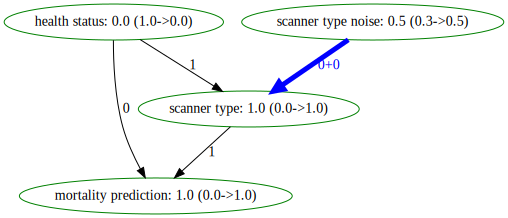

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


In [7]:
cf = CreditFlow(graph, verbose=True, nruns=1, visualize=True)
cf.run()

In [2]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import Node, CreditFlow, Graph, flatten_graph, eval_graph, get_source_nodes, single_source_graph, boundary_graph, viz_graph, save_graph
from collections import defaultdict

# 0 baseline model

$\text{health status} \in \{0, 1\}$

$\text{portable scanner} \in \{0, 1\}$

$\text{mortality probability prediction} \in [0, 1]$


```python
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True) # U(0, 1)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
```

bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

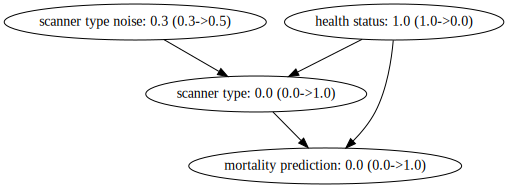


----> using order [health status, scanner type noise]
baselines health status: 1, scanner type noise: 0.3
turn on edge from external source to health status
health status changes from 1 to 0


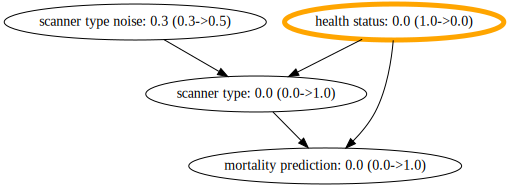

turn on edge health status->scanner type
scanner type changes from 0 to 1


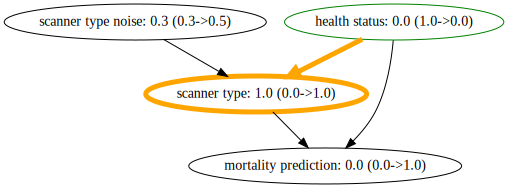

turn on edge scanner type->mortality prediction
mortality prediction changes from 0 to 1


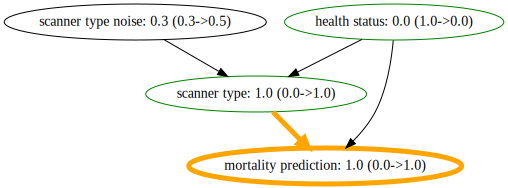

assign 1 credits to scanner type->mortality prediction


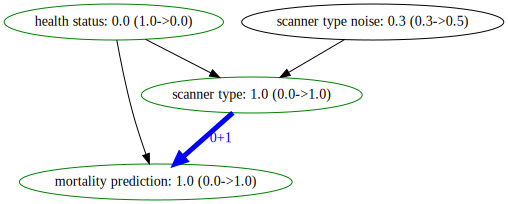

assign 1 credits to health status->scanner type


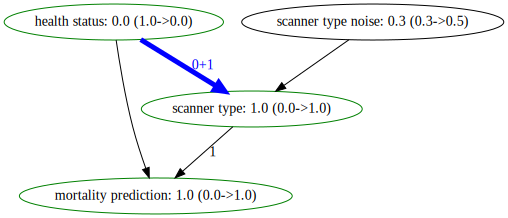

turn on edge health status->mortality prediction
mortality prediction changes from 1 to 1


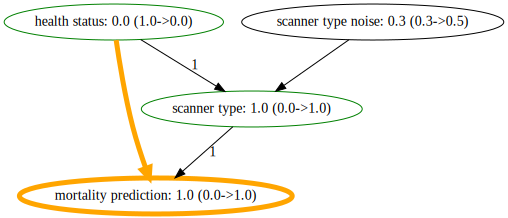

assign 0 credits to health status->mortality prediction


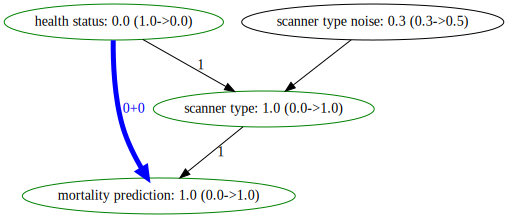

turn on edge from external source to scanner type noise
scanner type noise changes from 0.3 to 0.5


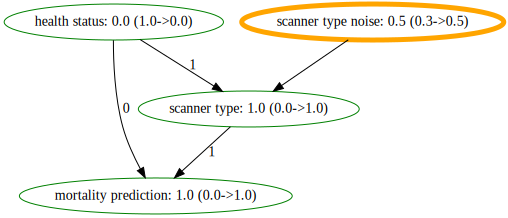

turn on edge scanner type noise->scanner type
scanner type changes from 1 to 1


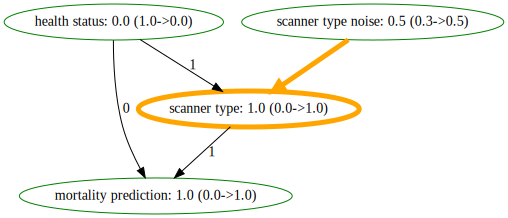

turn on edge scanner type->mortality prediction
mortality prediction changes from 1 to 1


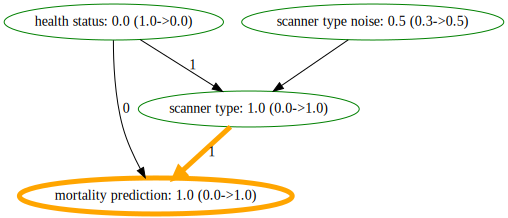

assign 0 credits to scanner type->mortality prediction


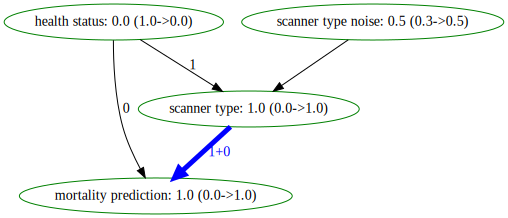

assign 0 credits to scanner type noise->scanner type


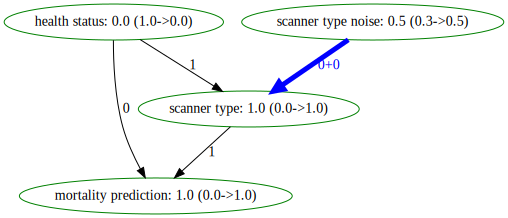

bruteforce sampling: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


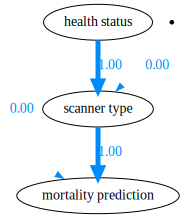

In [3]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: 1,
                     'scanner type noise': lambda: 0.3 # np.random.uniform(0, 1)
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: 0.5 # np.random.uniform(0, 1),
                 })
   
    return graph

graph = build_health_graph()
verbose = True
cf = CreditFlow(graph, verbose=verbose, nruns=1, visualize=verbose)
cf.run()

cf.draw()

bruteforce sampling: 100%|██████████| 1000/1000 [00:00<00:00, 3286.46it/s]


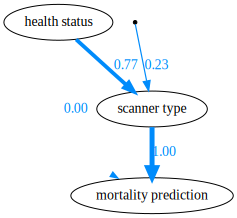

In [38]:
'''
current value: health status, scanner type, mortality
{
    (0, 1, 1): [(0-1, 0-0.89999)]
    (0, 0, 0): [(0-1. 0.9-1)]
}

to make sure value changes from (1, 0, 0) -> (0, 1, 1)
we need baseline noise 0.3-1
        target noise 0-0.899999
'''

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: 1,
                     'scanner type noise': lambda: np.random.uniform(0.3, 1)
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9),
                 })
   
    return graph

graph = build_health_graph()
cf = CreditFlow(graph, verbose=False, nruns=1000)
cf.run()

cf.draw()

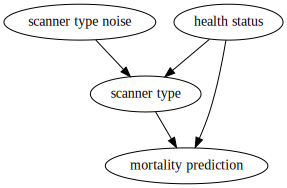

In [39]:
graph.draw()

Health status has limited effect in this case when

1. target noise < 0.3 (health status has no effect when applied second)
2. base noise > 0.9 (health status has no effect when applied first)

which has probablity $1/3 * 1/2 + 1/7 * 1/2 = 0.238$, matching the result we saw here in simulation.

# More realistic setup: baseline allows to vary

bruteforce sampling: 100%|██████████| 1000/1000 [00:00<00:00, 1866.35it/s]


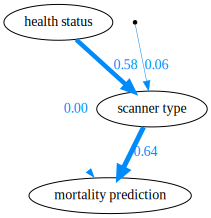

In [5]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: np.random.choice([0, 1], p=[0.1, 0.9]),
                     'scanner type noise': lambda: np.random.uniform(0, 1) # relax baseline
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })
   
    return graph

graph = build_health_graph()
cf = CreditFlow(graph, verbose=False, nruns=1000)
cf.run()

cf.draw()

# Demonstrating a causal understanding of the system by taking a test with cheatsheet

bruteforce sampling: 100%|██████████| 1000/1000 [00:00<00:00, 2030.49it/s]


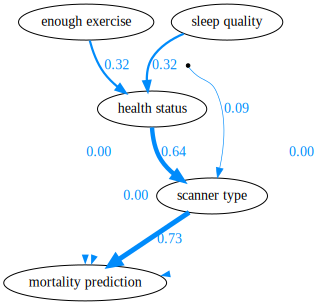

In [47]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x00 = Node('enough exercise') # [0, 1]
    x01 = Node('sleep quality') # [0, 1]
    x1 = Node('health status', lambda x00, x01: x00 and x01, [x00, x01])
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x00, x01, x1, x2: x2, 
              [x00, x01, x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x00, x01, x1, n2, x2, y],
                 {
                      'enough exercise': lambda: 1,
                      'sleep quality': lambda: 1, 
                      'scanner type noise': lambda: np.random.uniform(0, 1)
                 },
                 {
                      'enough exercise': lambda: 0,
                      'sleep quality': lambda: 0,
                      'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })
   
    return graph

graph = build_health_graph()
# graph = boundary_graph(graph)
cf = CreditFlow(graph, verbose=False, nruns=1000)
cf.run()

cf.draw()

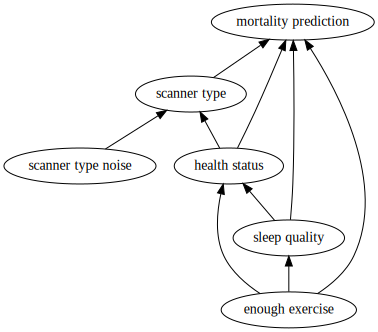

In [99]:
g = graph.draw()

In [101]:
save_graph(graph.to_graphviz(), 'figures/scanner.png')

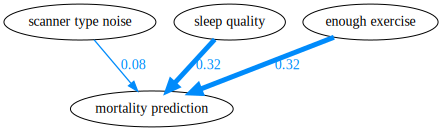

In [37]:
# bgraph = boundary_graph(graph)
# verbose = False
# cf = CreditFlow(bgraph, verbose=verbose, nruns=1000, visualize=verbose, fold_noise=False)
# cf.run()
cf.fold_noise = False
cf.draw_asv()

bruteforce sampling: 100%|██████████| 300/300 [00:00<00:00, 2087.30it/s]


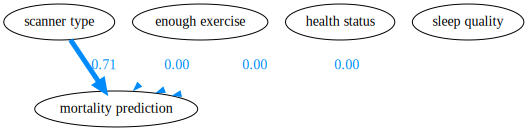

In [7]:
shap_graph = flatten_graph(graph)
verbose = False
cf = CreditFlow(shap_graph, verbose=verbose, nruns=300, visualize=verbose)
cf.run()

cf.draw()

In [9]:
print('fix other variables but only change health status')
sources = get_source_nodes(graph)
d = dict((node.name, 1) for node in sources)
d.update({'health status': 0, 'scanner type noise': 0.4})
print(d)
print('output:', eval_graph(graph, d))

sources = get_source_nodes(graph)
d = dict((node.name, 1) for node in sources)
d.update({'health status': 1, 'scanner type noise': 0.4})
print(d)
print('output:', eval_graph(graph, d))

fix other variables but only change health status
{'enough exercise': 1, 'scanner type noise': 0.4, 'sleep quality': 1, 'health status': 0}
output: [1]
{'enough exercise': 1, 'scanner type noise': 0.4, 'sleep quality': 1, 'health status': 1}
output: [0]


bruteforce sampling: 100%|██████████| 5000/5000 [00:02<00:00, 2330.48it/s]


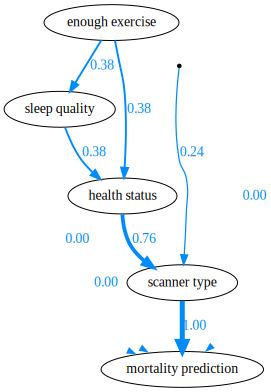

In [84]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x00 = Node('enough exercise') # [0, 1]
    x01 = Node('sleep quality', lambda x00: x00, [x00]) # [0, 1]
    x1 = Node('health status', lambda x00, x01: x00 and x01, [x00, x01])
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: (0.9 > n2 if x1 <= 0.1 else 0.3 > n2).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x00, x01, x1, x2: x2, 
              [x00, x01, x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x00, x01, x1, n2, x2, y],
                 {
                      'enough exercise': lambda: 1,
                      #'sleep quality': lambda: 1, 
                      'scanner type noise': lambda: np.random.uniform(0.3, 1) # so that baseline of mortality 0
                 },
                 {
                      'enough exercise': lambda: 0,
                      #'sleep quality': lambda: 0,
                      'scanner type noise': lambda: np.random.uniform(0, 0.9), # so that baseline of mortality 1
                 })
   
    return graph

graph = build_health_graph()
# graph = boundary_graph(graph)
cf = CreditFlow(graph, verbose=False, nruns=5000)
cf.run()
# cf = CreditFlow(graph, verbose=False, nruns=-1)
# cf.run(method='divide_and_conquer')

g = cf.draw()

In [86]:
save_graph(g, 'figures/synthetic_flow.png')

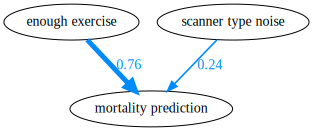

In [87]:
cf.fold_noise = False
g = cf.draw_asv()
save_graph(g, 'figures/synthetic_asv.png')

bruteforce sampling: 100%|██████████| 1000/1000 [00:00<00:00, 2494.56it/s]


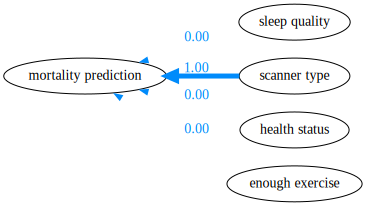

In [98]:
shap_graph = flatten_graph(graph)
verbose = False
cf2 = CreditFlow(shap_graph, verbose=verbose, nruns=1000, visualize=verbose, rankdir='RL')
cf2.run()

g = cf2.draw()
save_graph(g, 'figures/synthetic_shap.png')